# Importando Bibliotecas

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,Conv2D
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import itertools

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

# Funções de Plot

In [2]:
# Plotando barras

def plot_bar(num_n, num_p, num_tr, num_tt,num_t_n, num_t_p):
# num_train_normal, num_train_pneumonia
    #nind = numpy
    ind = np.arange(1)
    loc = [ind, ind+0.75]
    width = 0.7

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

    ax1.bar(loc[0], num_n, width=width, color='r')
    ax1.bar(loc[1], num_p, width=width, color='b')
    ax1.legend(labels=['Normal', 'Pneumonia'])
    ax1.set_ylabel('N° Data')
    ax1.set_xticks(loc)
    ax1.set_xticklabels(labels=['Normal', 'Pneumonia'])
    ax1.set_yticks(np.arange(0,6000, 500))
    ax1.set_title('Amount of Data by Classes ')

    ax2.bar(loc[0],num_tr, width=width, color='r')
    ax2.bar(loc[1], num_tt, width=width, color='b')
    ax2.legend(labels=['Train', 'Test'])
    ax2.set_ylabel('N° Data')
    ax2.set_xticks(loc)
    ax2.set_xticklabels(labels=['Train', 'Test'])
    ax2.set_yticks(np.arange(0,6000, 500))
    ax2.set_title('Amount of Data by Train/Test ')

    ax3.bar(loc[0],num_t_n, width=width, color='r')
    ax3.bar(loc[1], num_t_p, width=width, color='b')
    ax3.legend(labels=['Normal', 'Pneumonia'])
    ax3.set_ylabel('N° Data')
    ax3.set_xticks(loc)
    ax3.set_xticklabels(labels=['Normal', 'Pneumonia'])
    ax3.set_yticks(np.arange(0,6000, 500))
    ax3.set_title('Amount of Data per Classes in Train ')

    plt.tight_layout()

    return

#Plotando as metricas, precision, recall binary_accuracy e loss

def plot_metrics(histor):
    history = histor
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'binary_accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met.upper()))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        ax[i].grid(linestyle='--',linewidth = 1.2)

    return

#import itertools
def plot_confusion_matrix(cm_test,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Matriz de confusão
    cm = cm_test

    # Classe do plot 
    classes = ['PNEUMONIA', 'NORMAL']

    if normalize:

        tp = cm[0,0]
        tn = cm[1,1]
        fp = cm[1,0]
        fn = cm[0,1]

        # True positive rate => True Positive / (True Positive + False Negative)
        tpr = round((tp/(tp+fn)), 3)

        # False Positive rate => False Positive / (False Positive + Truen Negative)
        fpr = round((fp/(fp+tn)),3)

        # True Negative rate => True Negative / (True Negative + False Positve)
        tnr = round((tn/(tn+fp)),3)

        # False Negative rate => False Negative / (False Negative + Truen Positve)
        fnr = round((fn/(fn+tp)),3)
        
        cm = [[tpr, fnr],[fpr, tnr]]

        cm = np.array(cm)

        #print("Normalized confusion matrix")
    else:
        print('')

    plt.figure(figsize = (10,5))
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return

# Plotando a curva roc 
def plot_curva_roc(y_test, y_pred, fig_size):
    
    # Calculo do ROC
    fpr,tpr, threshold = roc_curve(y_test, y_pred)
    auc_new = auc(fpr, tpr)

    # PLOT CURVE ROC
    plt.figure(figsize= fig_size)
    plt.plot(fpr, tpr, color ='orange', linewidth = 2)
    plt.plot([0, 1], [0, 1],color='darkblue', linestyle='--')
    plt.legend([f'ROC (AUC = {round(auc_new, 4)})'])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    return 


# Google Drive - Database

In [3]:
# Montando um drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## data directories

In [4]:
# Todos os Diretorios

# Principal
main_dir = '/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/dataset'
train_dir = '/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/dataset/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/dataset/test'
roots_dir = '/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/'
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/checkpoint/'

# Caminho do Conjunto de Train
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Caminho do Conjunto de Test
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

# Caminho das imagens utilizadas no Grad-CAM
SAMPLES_DIR = '/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/grad_cam/'

## high-RAM runtime

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


# Data analysis

In [7]:
# Conjunto de Train
train_pneumonia = os.listdir(train_pneumonia_dir)   # buscando as imagens do diretorio de treino-pneumonia
train_normal = os.listdir(train_normal_dir)         # buscando as imagens do diretorio de treino-normal

# Conjunto de Teste
test_pneumonia = os.listdir(test_pneumonia_dir)
test_normal =  os.listdir(test_normal_dir)

print('Train set:')
print('--'*15)
print(f'PNEUMONIA={len(train_pneumonia)}')
print(f'NORMAL={len(train_normal)}')
print('--'*15)

print('\n')
print('Test set:')
print('--'*15)
print(f'PNEUMONIA={len(test_pneumonia)}')
print(f'NORMAL={len(test_normal)}')
print('--'*15)

Train set:
------------------------------
PNEUMONIA=3883
NORMAL=1349
------------------------------


Test set:
------------------------------
PNEUMONIA=390
NORMAL=234
------------------------------


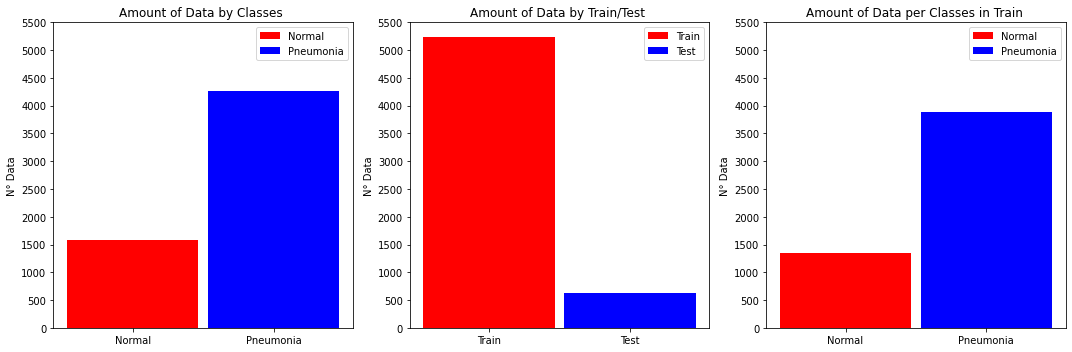

In [8]:
# Quantidade de Dados da Classe Normal
num_data_normal = len(train_normal) + len(test_normal)

# Quantidade de Dados da Classe Pneumonia
num_data_pneumonia = len(train_pneumonia) + len(test_pneumonia)

#Quantidade de Dados de Train
num_data_train = len(train_normal) + len(train_pneumonia)

#Quantidade de Dados de Test
num_data_test = len(test_normal) + len(test_pneumonia)

#Quantidade de Norma no Conjunto de Train
num_train_normal = len(train_normal)

#Quantidade de Pneumonia no Conjunto de Train
num_train_pneumonia = len(train_pneumonia)

#Plot
plot_bar(num_data_normal, num_data_pneumonia, num_data_train, num_data_test, num_train_normal, num_train_pneumonia)


## Visualizando Dados de Treino - NORMAL

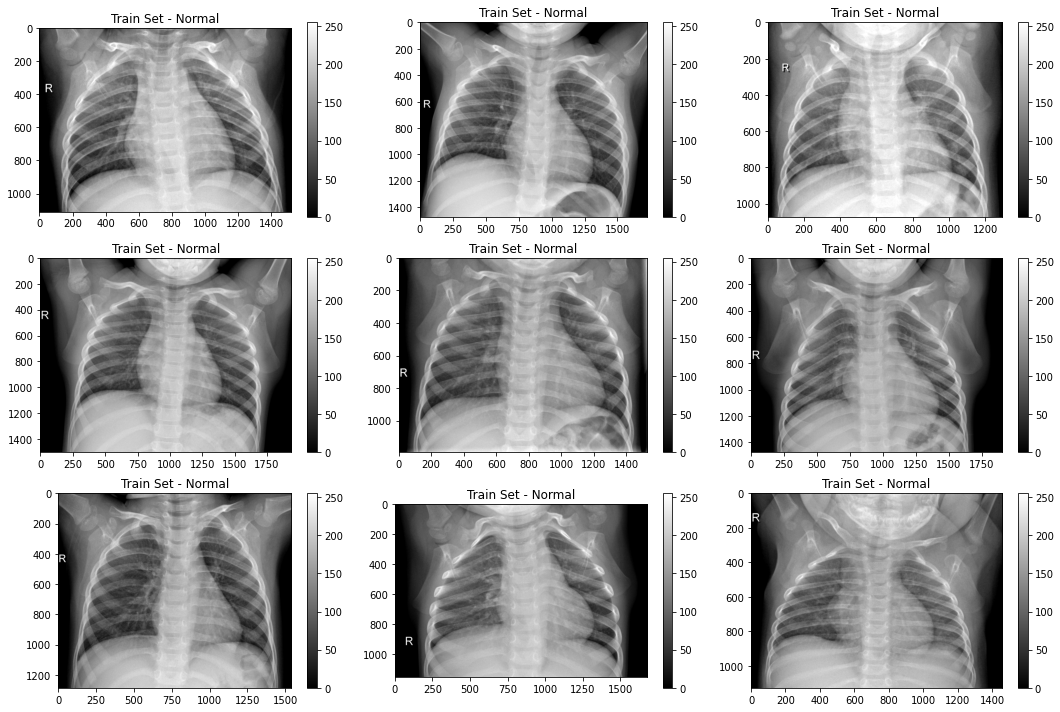

In [9]:
# Plotando Imagens de Train - Normal
plt.figure(figsize=(15, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(train_normal_dir,train_normal[i]))
    plt.imshow(img, cmap='gray')
    plt.title('Train Set - Normal')
    plt.colorbar()

plt.tight_layout()

### Visualizando Dados de Treino - PNEUMONIA

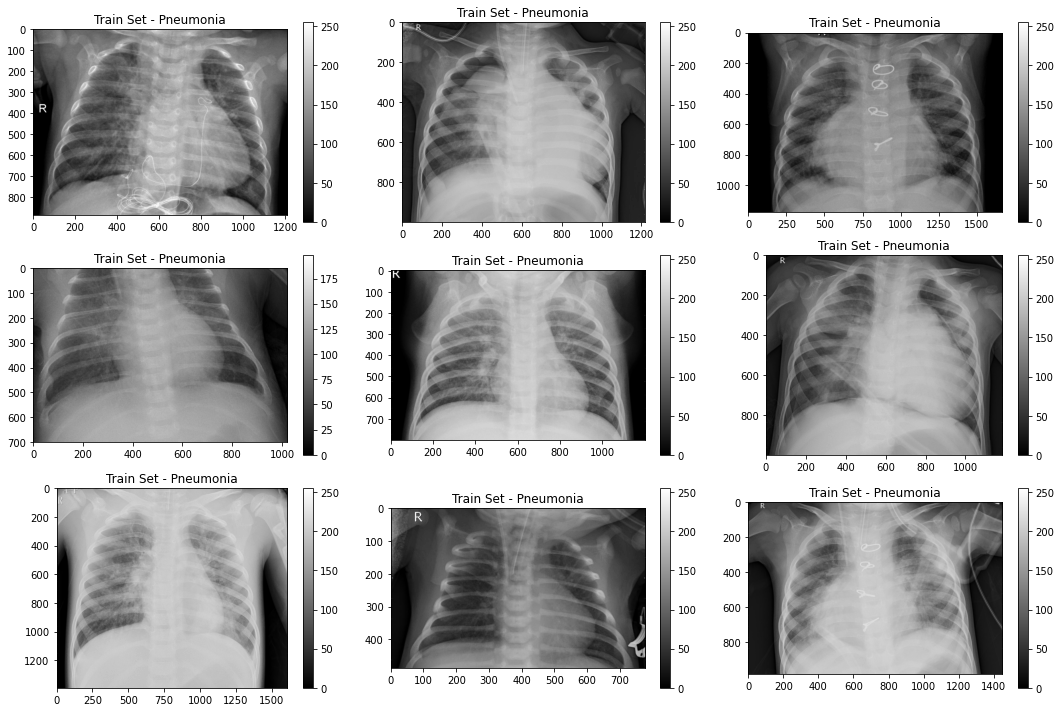

In [10]:
# Plotando Imagens de Train - Pneumonia

plt.figure(figsize=(15, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(train_pneumonia_dir,train_pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.title('Train Set - Pneumonia')
    plt.colorbar()

plt.tight_layout()

# Data Leakage - Vazamento de Dados


In [11]:
def data_leakage(set_train,set_test):

    # Transformando a lista em conjunto
    set1, set2 = set(set_train), set(set_test)
    
    # primeiro- intersecção entre o conjunto 1 e conjunto 2,3 e 4
    first = list(set1.intersection(set2))

    print('Quantidade de dados vazados: ', len(first))

    return 


In [12]:
# Apenas Simulação
# Teste da função de vazamento de dados
temp1 = [1,2,3,4,5]         # Lista 1
temp2 = [3,4,5,6,7]         # Lista 2

print('Simulação:\n')

# Função de detecção de vazamento de dados
data_leakage(temp1,temp2)   # 3 dados estão presentes em dois conjuntos, os numeros 3,4 e 5

print('')

temp1 = [1,2,3,4,5]         # Lista 1
temp2 = [6,7]               # Lista 2
data_leakage(temp1,temp2)   # Nenhum dado foi vazado!


Simulação:

Quantidade de dados vazados:  3

Quantidade de dados vazados:  0


In [13]:
# Testando vazamento de Dados
set_train = train_normal + train_pneumonia  # Concatenando as listas
set_test = test_normal + test_pneumonia     # Concatenando as listas

# Função de detecção de vazamento de dados
data_leakage(set_train,set_test )

Quantidade de dados vazados:  0


# Correct for data imbalance

In [14]:
# Calculo para determinar se o conjunto de dados está balanceado
initial = np.absolute(np.log([num_train_pneumonia/num_train_normal]))          

print('Pneumonia Images Count in Traing Set: ', num_train_pneumonia)
print('   Normal Images Count in Traing Set: ', num_train_normal)
print('\n')

# Se log 1 = zero, Então esta balanceado
# Se for diferente está desbalanceado

if initial != 0: 

    # equação para determinar os pesos de cada clase
    weight_for_normal = (1 / num_train_normal)*(num_data_train/2.0)             # 0,5(Pne/normal) + 0,5
    weight_for_pneumonia = (1 / num_train_pneumonia)*(num_data_train/2.0)       # 0,5(normal/Pne) + 0,5

    class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}              # Salvando os pesos em dicionario

    print('Weight for class Pneumonia: {:.2f}'.format(weight_for_pneumonia))
    print('   Weight for class Normal: {:.2f}'.format(weight_for_normal))
    
else: 
    print('balanced Data')


print('\nNormal : ', num_train_normal * weight_for_normal)
print('Pneumo : ',num_train_pneumonia* weight_for_pneumonia)


#     O peso da classe 0 (Normal) é muito maior do que o peso da classe 1 (Pneumonia).
#     Como há menos imagens normais, cada imagem normal terá mais peso para equilibrar os dados,
#     pois o CNN funciona melhor quando os dados de treinamento são equilibrados.

Pneumonia Images Count in Traing Set:  3883
   Normal Images Count in Traing Set:  1349


Weight for class Pneumonia: 0.67
   Weight for class Normal: 1.94

Normal :  2616.0
Pneumo :  2616.0


# Normalization - Resizing - Division of Data

In [15]:
#Data preprocessing and analysis
classes = ["NORMAL", "PNEUMONIA"]

# Shape Input Image
image_size = 400    # 400x400
batch = 32

# determinando o input shape
input_shape = (image_size,image_size)

#Rescalonamento, normalização e separação do conjunto de validação em 20%
data_gen = ImageDataGenerator(  
                                samplewise_center = True,
                                samplewise_std_normalization = True,
                                rescale=1./255,
                                validation_split=0.2
                              ) 

# Train Batches 
train_batches = data_gen.flow_from_directory(
                                train_dir, 
                                target_size = input_shape, 
                                classes = classes, 
                                class_mode = "binary",
                                batch_size=batch, 
                                shuffle=True,
                                subset='training'
                                )

# Val Batches em 20%
val_batches = data_gen.flow_from_directory(
                                train_dir, 
                                target_size = input_shape, 
                                classes = classes, 
                                class_mode = "binary",
                                batch_size=batch, 
                                shuffle=True,
                                subset='validation'
                                )


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [16]:
#Rescalonamento, normalização.
data_gen_test = ImageDataGenerator(
                                samplewise_center = True,
                                samplewise_std_normalization = True,
                                rescale=1./255) 

#Test Batches
test_batches = data_gen_test.flow_from_directory(
                                test_dir, 
                                target_size = input_shape, 
                                classes = classes, 
                                class_mode = "binary",
                                batch_size=batch, 
                                shuffle=False,
                                )

Found 624 images belonging to 2 classes.


In [17]:
# Visualizando as classes
train_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Data Augmentation

In [35]:
def data_aug(inputs):

    data_augmentation = keras.Sequential(
        [
         
            layers.experimental.preprocessing.RandomRotation(0.1,fill_mode='constant'),
            layers.experimental.preprocessing.RandomZoom(0.1,fill_mode='constant'),
            layers.experimental.preprocessing.RandomTranslation(
                                                                height_factor = 0.1, 
                                                                width_factor = 0.1,
                                                                fill_mode='constant')
        ]
    )

    x = data_augmentation(inputs)
    return x

## Visualizando Data Augmentation

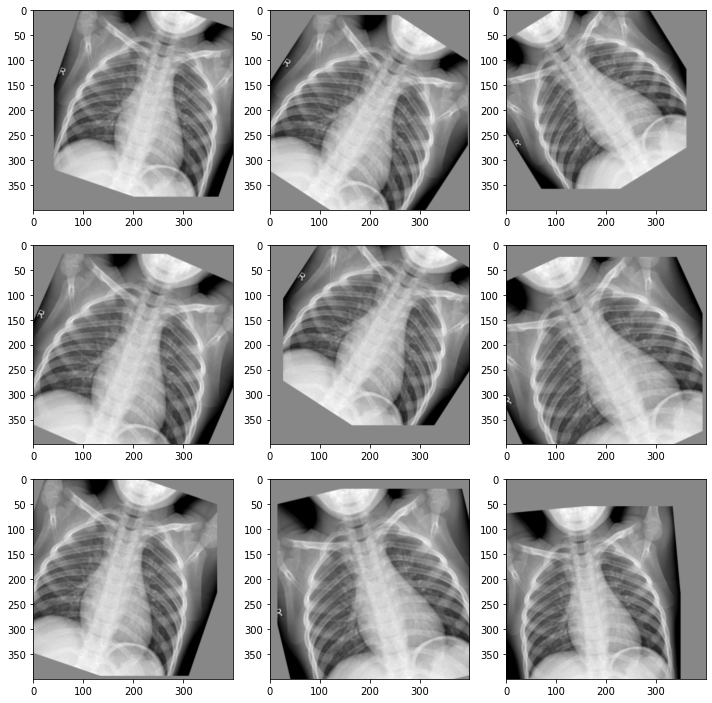

In [36]:
images, labels = train_batches.__getitem__(0)

plt.figure(figsize=(10, 10))
first_image = images[0]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_aug(tf.expand_dims(first_image, 0))
    a = augmented_image.numpy()
    plt.imshow(a[0,:,:,0], cmap='gray')
    plt.tight_layout()

# Minha Rede

In [37]:
# Meu modelo
def my_model(base_model, input_layers):

    tf.random.set_seed(seed=42)

    # Camada de entrada
    inputs = keras.Input(shape=input_layers)

    # chamando a funçao de data augmentation
    x = data_aug(inputs)  

    # Chamando a rede pré-Treinada transfer learning
    x = base_model(x)

    # Camada de Pooling
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Camada Dropout
    x = keras.layers.Dropout(0.2)(x)

    # Camada de saida, com um neuronio e função de ativação sigmoid 
    outputs = layers.Dense(1, activation="sigmoid")(x)      # representando a classificação binaria

    return inputs, outputs


In [38]:
def opt_stop_reduce(lr):
    
    # Otimizador Adam - com Learning rate
    opt = keras.optimizers.Adam(learning_rate=lr)

    # Adicionando Callbacks

    # Monitorando a val_loss, e definindo limites para parar o treinamento. 
    early_stopping_monitor = EarlyStopping(
                                            monitor = 'val_loss',
                                            patience = 5,
                                            mode="auto",
                                            restore_best_weights=True
                                        )
    
    # Monitorando a val_loss, e reduzindo a taxa de aprendizagem quando a metrica não apresenta melhoras.
    reduce_lr = ReduceLROnPlateau(
                                    monitor='val_loss', 
                                    factor=0.1, # new_lr = lr * factor
                                    patience=3,
                                    min_lr=1e-9
                                )
    
    #Checkpoint
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                    filepath=checkpoint_dir,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True
                                    )

    # Metricas utilizadas
    METRICS = [
                keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None),
                keras.metrics.Precision(name='precision'), # Precision
                keras.metrics.Recall(name='recall'),       # Recall
                keras.metrics.FalseNegatives(name="fn"),   # Falso Negativo
                keras.metrics.FalsePositives(name="fp"),   # Falso Positivo
                keras.metrics.TrueNegatives(name="tn"),    # Verdadeiro Negativo
                keras.metrics.TruePositives(name="tp")     # Verdadeiro Positvo
              ]
    
    return opt, early_stopping_monitor, reduce_lr, METRICS,checkpoint_callback

In [39]:
# Definindo a quantidade de passos por epochs 

#steps_train = número total de batches antes de declarar uma época concluída e iniciar a próxima etapa
steps_train = train_batches.n // train_batches.batch_size   # N° de amostras / batch, retornando um valor inteiro

#steps_val = número total de batches antes de declarar uma época concluída e iniciar a próxima etapa
steps_val = val_batches.n // val_batches.batch_size         # amostras / batch, retornando um valor inteiro

print('Steps Train: ',steps_train)
print('Steps Val: ',steps_val)

# Visualizando o shape das imagens de treino
print('\nShape das Imagens de Train: ',train_batches.image_shape)

Steps Train:  130
Steps Val:  32

Shape das Imagens de Train:  (400, 400, 3)


# Rede InceptionV3

In [51]:
def inceptionV3(inputs):
    base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=inputs) 

    return base_model

## Inception V3


In [52]:
%%time

tf.random.set_seed(seed=42)

#Taxa de aprendizado
lr = 1e-3

#Numero de Epochs
epoca = 15

# Otimizador, parada, redução da taxa de aprendizado
opt, early_stopping_monitor, reduce_lr, METRICS, checkpoint_callback =  opt_stop_reduce(lr)

#Shape das camadas de Entrada
input_layers = train_batches.image_shape  # 400,400,3

#Rede Inception
base_model = inceptionV3(input_layers)

# Freeze base model
base_model.trainable = False

#Meu Modelo
inputs, outputs = my_model(base_model, input_layers)

#Modelo
model_inception = keras.Model(inputs, outputs)

#Summary
model_inception.summary()


87916544/87910968 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_65 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainab

In [53]:
%%time

#Compilando
model_inception.compile(
                loss=keras.losses.BinaryCrossentropy(), 
                optimizer=opt,
                metrics=METRICS
            )

#Treinando
history__inception = model_inception.fit(
                    train_batches,      #early_stopping_monitor , , checkpoint_callback
                    epochs=epoca, callbacks=[reduce_lr, checkpoint_callback], 
                    validation_data=val_batches, 
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    class_weight=class_weight
                    )

Epoch 1/15
130/130 [==============================] - 74s 526ms/step - loss: 0.5377 - binary_accuracy: 0.7503 - precision: 0.8984 - recall: 0.7486 - fn: 347.6947 - fp: 104.3740 - tn: 439.2214 - tp: 1217.5267 - val_loss: 0.3712 - val_binary_accuracy: 0.8828 - val_precision: 0.9849 - val_recall: 0.8558 - val_fn: 110.0000 - val_fp: 10.0000 - val_tn: 251.0000 - val_tp: 653.0000
Epoch 2/15
130/130 [==============================] - 68s 520ms/step - loss: 0.2904 - binary_accuracy: 0.9121 - precision: 0.9706 - recall: 0.9088 - fn: 147.3359 - fp: 44.5344 - tn: 503.7786 - tp: 1412.0229 - val_loss: 0.2868 - val_binary_accuracy: 0.9062 - val_precision: 0.9770 - val_recall: 0.8949 - val_fn: 80.0000 - val_fp: 16.0000 - val_tn: 247.0000 - val_tp: 681.0000
Epoch 3/15
130/130 [==============================] - 68s 519ms/step - loss: 0.2436 - binary_accuracy: 0.9187 - precision: 0.9736 - recall: 0.9143 - fn: 136.2061 - fp: 39.7405 - tn: 509.5191 - tp: 1424.9160 - val_loss: 0.3609 - val_binary_accuracy:

## Fine Tuning - Inception V3

In [54]:
%%time

#Taxa de aprendizado
lr = 1e-5

#Numero de Epochs
epoca = 45

# Otimizador, parada, redução da taxa de aprendizado
opt, early_stopping_monitor, reduce_lr, METRICS, checkpoint_callback =  opt_stop_reduce(lr)


base_model.trainable = True

model_inception.summary()

#Compilando
model_inception.compile(
                loss=keras.losses.BinaryCrossentropy(), 
                optimizer=opt,
                metrics=METRICS
            )

#Treinando
history_inception = model_inception.fit(
                    train_batches,
                    epochs=epoca, 
                    callbacks=[reduce_lr, checkpoint_callback], 
                    validation_data=val_batches, 
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    class_weight=class_weight
                    )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_65 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
__________________________________________

## Salve InceptionV3 model 

In [55]:
# Testando um novo metodo de salvar os pesos do modelo
model_inception.save('/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/Pesos_Final/InceptionV3_v1.h5')

## InceptionV3 Results 

In [56]:
# Calculando o y_pred
y_pred_inception = model_inception.predict(test_batches)
y_pred = y_pred_inception

# Obtendo o y_test
y_true = test_batches.labels

# model evaluate
result_train = model_inception.evaluate(train_batches)
result_val = model_inception.evaluate(val_batches)
result_test = model_inception.evaluate(test_batches)

# extraindo accuracy do model evaluate
acc_train = result_train[1]
acc_val = result_val[1]
acc_test = result_test[1]


# Classes: Pneumonia = 1  , Normal = 0
# labels = [1, 0] -> labels = [Pneumonia, Normal]

# Calculo da F1 score
f1score = f1_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo da Precision
precision = precision_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo do Recall
recall = recall_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo da Matriz de Confusão
cm_test_incpetion = confusion_matrix(y_true, y_pred.round(), labels= [1,0])

print('='*35)
print(' '*10 + 'Pneumonia')
print('='*35)
print(' Test Precision: {:.4}%'.format(precision[0]*100))
print(' Test Recall: {:.4}%'.format(recall[0]*100))
print(' Test F1-Score: {:.4}%'.format(f1score[0]*100))
print('='*35)

print('='*35)
print(' '*10 + 'Normal')
print('='*35)
print(' Test Precision: {:.4}%'.format(precision[1]*100))
print(' Test Recall: {:.4}%'.format(recall[1]*100))
print(' Test F1-Score: {:.4}%'.format(f1score[1]*100))
print('='*35)

print('='*35)
print(' '*10 + 'Accuracy')
print('='*35)
print('Train Accuracy: {:.4}%'.format(acc_train*100))
print('  Val Accuracy: {:.4}%'.format(acc_val*100))
print(' Test Accuracy: {:.4}%'.format(acc_test*100))
print('='*35)

20/20 [==============================] - 7s 337ms/step - loss: 0.5199 - binary_accuracy: 0.8510 - precision: 0.8140 - recall: 0.9872 - fn: 5.0000 - fp: 88.0000 - tn: 146.0000 - tp: 385.0000
          Pneumonia
 Test Precision: 81.4%
 Test Recall: 98.72%
 Test F1-Score: 89.22%
          Normal
 Test Precision: 96.69%
 Test Recall: 62.39%
 Test F1-Score: 75.84%
          Accuracy
Train Accuracy: 98.95%
  Val Accuracy: 97.22%
 Test Accuracy: 85.1%


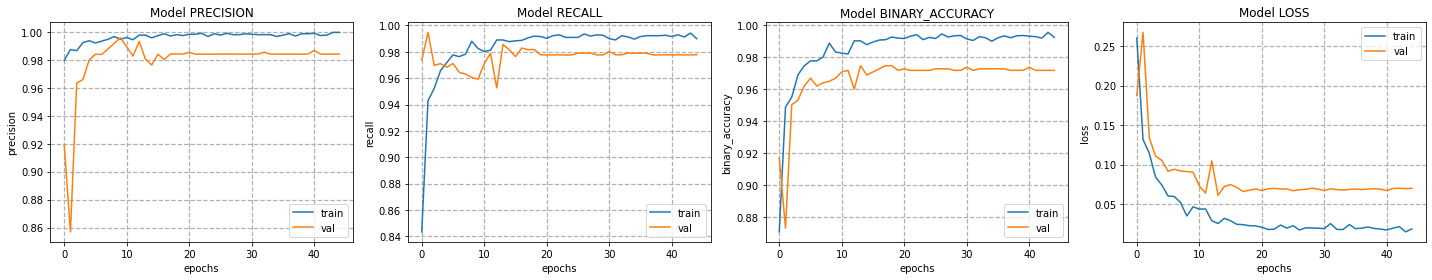

In [57]:
#Plotando as metricas - recall, precision, loss e binary_accuracy
plot_metrics(history_inception)
plt.tight_layout()

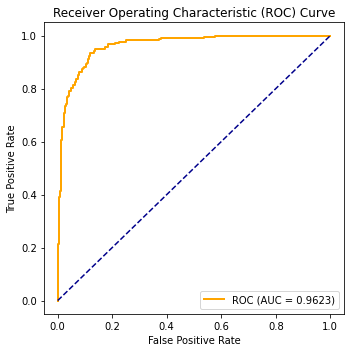

In [58]:
#Plot da curva roc 
fig_size = (5,5)
plot_curva_roc(y_true, y_pred_inception,fig_size)
plt.tight_layout()

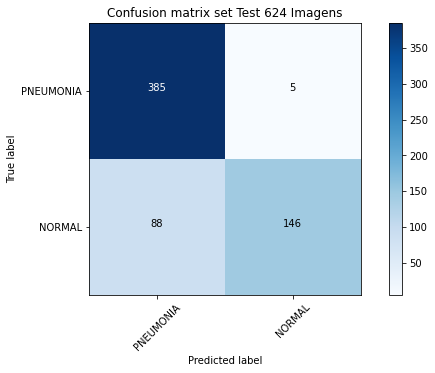

In [59]:
#plot da matriz de confusao
plot_confusion_matrix(cm_test_incpetion, normalize=False, title='Confusion matrix set Test 624 Imagens', cmap=plt.cm.Blues)

# 234  imagens - Classe normal
# 390  imagens - classe Pneumonia

## Load Saved InceptionV3 Model

In [ ]:
#Testando o carregamento dos pesos.
model_inception_reconstructed = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/Pesos_Final/InceptionV3_v1.h5')

history_inception_reconstructed = model_inception_reconstructed.fit(test_batches)
history_inception_reconstructed

20/20 [==============================] - 8s 415ms/step - loss: 1.9601 - binary_accuracy: 0.6554 - precision: 0.6654 - recall: 0.9026 - fn: 38.0000 - fp: 177.0000 - tn: 57.0000 - tp: 352.0000


# Rede InceptionResNetV2

In [ ]:
def inception_res_netV2(inputs):

    base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=inputs)

    return base_model

## InceptionResNetV2

In [ ]:
%%time

tf.random.set_seed(42)

#Taxa de aprendizado
lr = 1e-3

#Numero de Epochs
epoca = 15

# Otimizador, parada, redução da taxa de aprendizado
opt, early_stopping_monitor, reduce_lr, METRICS, checkpoint_callback =  opt_stop_reduce(lr)

#Shape das camadas de Entrada
input_layers = train_batches.image_shape  # 400,400,3

#Rede InceptionResNetV2
base_model = inception_res_netV2(input_layers)

# Freeze base model
base_model.trainable = False

#Meu Modelo
inputs, outputs = my_model(base_model, input_layers)

#Modelo
model_inception_resnet_v2 = keras.Model(inputs, outputs)

#Summary
model_inception_resnet_v2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 11, 11, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
______________________________________

In [ ]:
%%time

#Compilando
model_inception_resnet_v2.compile(
                loss=keras.losses.BinaryCrossentropy(), 
                optimizer=opt,
                metrics=METRICS
            )

#Treinando
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
                    train_batches,      #early_stopping_monitor , , checkpoint_callback
                    epochs=epoca, callbacks=[reduce_lr, checkpoint_callback], 
                    validation_data=val_batches, 
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    class_weight=class_weight
                    )

Epoch 1/15
130/130 [==============================] - 80s 618ms/step - loss: 0.4491 - binary_accuracy: 0.8084 - precision: 0.9300 - recall: 0.8019 - fn: 610.0000 - fp: 186.0000 - tn: 889.0000 - tp: 2470.0000 - val_loss: 0.3351 - val_binary_accuracy: 0.8750 - val_precision: 0.9938 - val_recall: 0.8375 - val_fn: 124.0000 - val_fp: 4.0000 - val_tn: 257.0000 - val_tp: 639.0000
Epoch 2/15
130/130 [==============================] - 78s 602ms/step - loss: 0.3123 - binary_accuracy: 0.8816 - precision: 0.9628 - recall: 0.8741 - fn: 388.0000 - fp: 104.0000 - tn: 969.0000 - tp: 2694.0000 - val_loss: 0.2737 - val_binary_accuracy: 0.8955 - val_precision: 0.9955 - val_recall: 0.8635 - val_fn: 104.0000 - val_fp: 3.0000 - val_tn: 259.0000 - val_tp: 658.0000
Epoch 3/15
130/130 [==============================] - 77s 595ms/step - loss: 0.2624 - binary_accuracy: 0.8972 - precision: 0.9700 - recall: 0.8892 - fn: 342.0000 - fp: 85.0000 - tn: 984.0000 - tp: 2744.0000 - val_loss: 0.2776 - val_binary_accuracy:

## Fine Tuning - InceptionResnetV2

In [ ]:
%%time

#Taxa de aprendizado
lr = 1e-5

#Numero de Epochs
epoca = 45

# Otimizador, parada, redução da taxa de aprendizado
opt, early_stopping_monitor, reduce_lr, METRICS, checkpoint_callback =  opt_stop_reduce(lr)


base_model.trainable = True

model_inception_resnet_v2.summary()

#Compilando
model_inception_resnet_v2.compile(
                loss=keras.losses.BinaryCrossentropy(), 
                optimizer=opt,
                metrics=METRICS
            )

#Treinando
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
                    train_batches,
                    epochs=epoca, 
                    callbacks=[reduce_lr, checkpoint_callback], 
                    validation_data=val_batches, 
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    class_weight=class_weight
                    )


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 11, 11, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_____________________________________

## Salve Inception ResNet V2 model 

In [ ]:
# Testando um novo metodo de salvar os pesos do modelo
model_inception_resnet_v2.save('/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/Pesos_Final/InceptionResnetV2_v1.h5')

## Inception ResNet V2 Results 

In [ ]:
# Calculando o y_pred
y_pred_inception_resnet_v2 = model_inception_resnet_v2.predict(test_batches)
y_pred = y_pred_inception_resnet_v2

# Obtendo o y_test
y_true = test_batches.labels

# model evaluate
result_train = model_inception_resnet_v2.evaluate(train_batches)
result_val = model_inception_resnet_v2.evaluate(val_batches)
result_test = model_inception_resnet_v2.evaluate(test_batches)

# extraindo accuracy do model evaluate
acc_train = result_train[1]
acc_val = result_val[1]
acc_test = result_test[1]


# Classes: Pneumonia = 1  , Normal = 0
# labels = [1, 0] -> labels = [Pneumonia, Normal]

# Calculo da F1 score
f1score = f1_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo da Precision
precision = precision_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo do Recall
recall = recall_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo da Matriz de Confusão
cm_test_inception_resnet_v2 = confusion_matrix(y_true, y_pred.round(), labels= [1,0])

print('='*35)
print(' '*10 + 'Pneumonia')
print('='*35)
print(' Test Precision: {:.4}%'.format(precision[0]*100))
print(' Test Recall: {:.4}%'.format(recall[0]*100))
print(' Test F1-Score: {:.4}%'.format(f1score[0]*100))
print('='*35)

print('='*35)
print(' '*10 + 'Normal')
print('='*35)
print(' Test Precision: {:.4}%'.format(precision[1]*100))
print(' Test Recall: {:.4}%'.format(recall[1]*100))
print(' Test F1-Score: {:.4}%'.format(f1score[1]*100))
print('='*35)

print('='*35)
print(' '*10 + 'Accuracy')
print('='*35)
print('Train Accuracy: {:.4}%'.format(acc_train*100))
print('  Val Accuracy: {:.4}%'.format(acc_val*100))
print(' Test Accuracy: {:.4}%'.format(acc_test*100))
print('='*35)

20/20 [==============================] - 8s 375ms/step - loss: 0.3769 - binary_accuracy: 0.8750 - precision: 0.8451 - recall: 0.9795 - fn: 8.0000 - fp: 70.0000 - tn: 164.0000 - tp: 382.0000
          Pneumonia
 Test Precision: 84.51%
 Test Recall: 97.95%
 Test F1-Score: 90.74%
          Normal
 Test Precision: 95.35%
 Test Recall: 70.09%
 Test F1-Score: 80.79%
          Accuracy
Train Accuracy: 98.14%
  Val Accuracy: 96.46%
 Test Accuracy: 87.5%


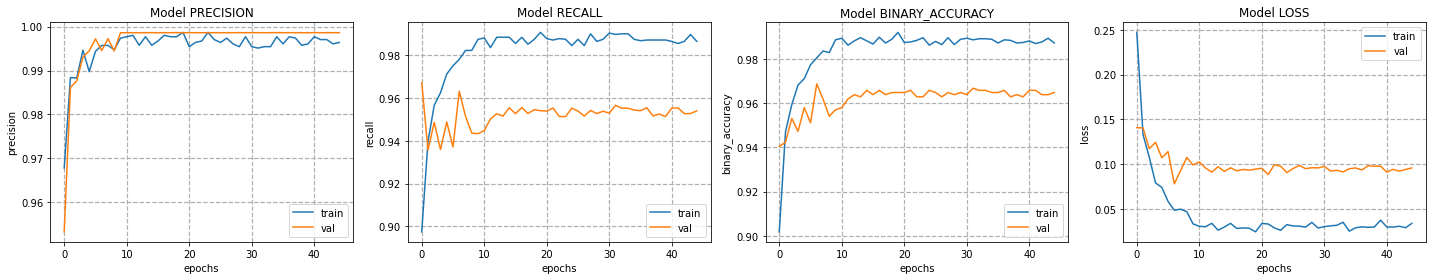

In [ ]:
#Plotando as metricas - recall, precision, loss e binary_accuracy
plot_metrics(history_inception_resnet_v2)
plt.tight_layout()

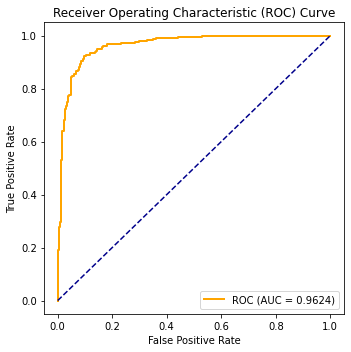

In [ ]:
#Plot da curva roc 
fig_size = (5,5)
plot_curva_roc(y_true, y_pred_inception_resnet_v2,fig_size)
plt.tight_layout()

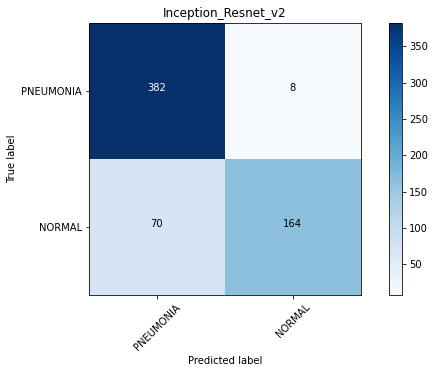

In [ ]:
#plot da matriz de confusao
plot_confusion_matrix(cm_test_inception_resnet_v2, normalize=False, title='Inception_Resnet_v2', cmap=plt.cm.Blues)

# 234  imagens - Classe normal
# 390  imagens - classe Pneumonia

## Load Saved Inception Resnet V2 Model

In [ ]:
#Testando o carregamento dos pesos.
model_inception_resnet_v2_reconstructed = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/Pesos_Final/InceptionResnetV2_v1.h5')

history_inception_resnet_v2_reconstructed = model_inception_resnet_v2_reconstructed.fit(test_batches)
history_inception_resnet_v2_reconstructed

20/20 [==============================] - 12s 594ms/step - loss: 1.7361 - binary_accuracy: 0.6426 - precision: 0.6555 - recall: 0.9026 - fn: 38.0000 - fp: 185.0000 - tn: 49.0000 - tp: 352.0000


# Rede Xception

In [40]:
def Xception(inputs):

    base_model = keras.applications.Xception(
        weights="imagenet",  # pesos pré-treinados do ImageNet
        input_shape=inputs,
        include_top=False)

    return base_model

### Xception

In [41]:
%%time

tf.random.set_seed(42)

#Taxa de aprendizado
lr = 1e-3

#Numero de Epochs
epoca = 15

# Otimizador, parada, redução da taxa de aprendizado
opt, early_stopping_monitor, reduce_lr, METRICS, checkpoint_callback =  opt_stop_reduce(lr)

#Shape das camadas de Entrada
input_layers = train_batches.image_shape  # 400,400,3

#Rede Xception
base_model = Xception(input_layers)

# Freeze base model
base_model.trainable = False

#Meu Modelo
inputs, outputs = my_model(base_model, input_layers)

#Modelo
model_xception = keras.Model(inputs, outputs)

#Summary
model_xception.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_64 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 13, 13, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
___________________________________________

In [43]:
%%time

#Compilando
model_xception.compile(
                loss=keras.losses.BinaryCrossentropy(), 
                optimizer=opt,
                metrics=METRICS
            )

#Treinando
history_xception = model_xception.fit(
                    train_batches,
                    epochs=epoca, callbacks=[reduce_lr,checkpoint_callback], 
                    validation_data=val_batches, 
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    class_weight=class_weight
                    )

Epoch 1/15
130/130 [==============================] - 1974s 15s/step - loss: 0.3972 - binary_accuracy: 0.8213 - precision: 0.9168 - recall: 0.8364 - fn: 471.9389 - fp: 213.4733 - tn: 801.9313 - tp: 2505.8092 - val_loss: 0.3440 - val_binary_accuracy: 0.8887 - val_precision: 0.9864 - val_recall: 0.8617 - val_fn: 105.0000 - val_fp: 9.0000 - val_tn: 256.0000 - val_tp: 654.0000
Epoch 2/15
130/130 [==============================] - 70s 538ms/step - loss: 0.2808 - binary_accuracy: 0.9127 - precision: 0.9700 - recall: 0.9109 - fn: 148.2443 - fp: 41.0229 - tn: 499.6718 - tp: 1419.3817 - val_loss: 0.2957 - val_binary_accuracy: 0.9053 - val_precision: 0.9868 - val_recall: 0.8842 - val_fn: 88.0000 - val_fp: 9.0000 - val_tn: 255.0000 - val_tp: 672.0000
Epoch 3/15
130/130 [==============================] - 70s 536ms/step - loss: 0.2433 - binary_accuracy: 0.9153 - precision: 0.9730 - recall: 0.9104 - fn: 139.0076 - fp: 39.5725 - tn: 512.4580 - tp: 1416.5573 - val_loss: 0.2909 - val_binary_accuracy: 0

## Fine Tuning - Xception

In [44]:
%%time

#Taxa de aprendizado
lr = 1e-5

#Numero de Epochs
epoca = 45

# Otimizador, parada, redução da taxa de aprendizado
opt, early_stopping_monitor, reduce_lr, METRICS, checkpoint_callback =  opt_stop_reduce(lr)


base_model.trainable = True

model_xception.summary()

#Compilando
model_xception.compile(
                loss=keras.losses.BinaryCrossentropy(), 
                optimizer=opt,
                metrics=METRICS
            )

#Treinando
history_xception = model_xception.fit(
                    train_batches,
                    epochs=epoca, callbacks=[reduce_lr,checkpoint_callback], 
                    validation_data=val_batches, 
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    class_weight=class_weight
                    )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_64 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 13, 13, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
__________________________________________

## Salve Xception model 


In [45]:
# Testando um novo metodo de salvar os pesos do modelo
model_xception.save('/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/Pesos_Final/Xception_v1.h5')

## Xception Results 

In [46]:
# Calculando o y_pred
y_pred_xception = model_xception.predict(test_batches)
y_pred = y_pred_xception

# Obtendo o y_test
y_true = test_batches.labels

# model evaluate
result_train = model_xception.evaluate(train_batches)
result_val = model_xception.evaluate(val_batches)
result_test = model_xception.evaluate(test_batches)

# extraindo accuracy do model evaluate
acc_train = result_train[1]
acc_val = result_val[1]
acc_test = result_test[1]


# Classes: Pneumonia = 1  , Normal = 0
# labels = [1, 0] -> labels = [Pneumonia, Normal]

# Calculo da F1 score
f1score = f1_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo da Precision
precision = precision_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo do Recall
recall = recall_score(y_true, y_pred.round(), labels=[1, 0], average= None)

# Calculo da Matriz de Confusão
cm_test_xception = confusion_matrix(y_true, y_pred.round(), labels= [1,0])

print('='*35)
print(' '*10 + 'Pneumonia')
print('='*35)
print(' Test Precision: {:.4}%'.format(precision[0]*100))
print(' Test Recall: {:.4}%'.format(recall[0]*100))
print(' Test F1-Score: {:.4}%'.format(f1score[0]*100))
print('='*35)

print('='*35)
print(' '*10 + 'Normal')
print('='*35)
print(' Test Precision: {:.4}%'.format(precision[1]*100))
print(' Test Recall: {:.4}%'.format(recall[1]*100))
print(' Test F1-Score: {:.4}%'.format(f1score[1]*100))
print('='*35)

print('='*35)
print(' '*10 + 'Accuracy')
print('='*35)
print('Train Accuracy: {:.4}%'.format(acc_train*100))
print('  Val Accuracy: {:.4}%'.format(acc_val*100))
print(' Test Accuracy: {:.4}%'.format(acc_test*100))
print('='*35)

20/20 [==============================] - 8s 350ms/step - loss: 0.2512 - binary_accuracy: 0.9119 - precision: 0.9306 - recall: 0.9282 - fn: 28.0000 - fp: 27.0000 - tn: 207.0000 - tp: 362.0000
          Pneumonia
 Test Precision: 93.06%
 Test Recall: 92.82%
 Test F1-Score: 92.94%
          Normal
 Test Precision: 88.09%
 Test Recall: 88.46%
 Test F1-Score: 88.27%
          Accuracy
Train Accuracy: 92.95%
  Val Accuracy: 90.91%
 Test Accuracy: 91.19%


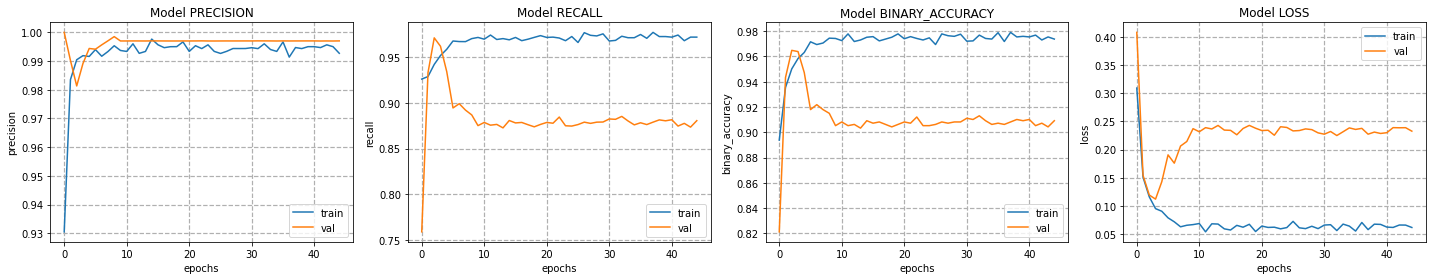

In [47]:
#Plotando as metricas - recall, precision, loss e binary_accuracy
plot_metrics(history_xception)
plt.tight_layout()

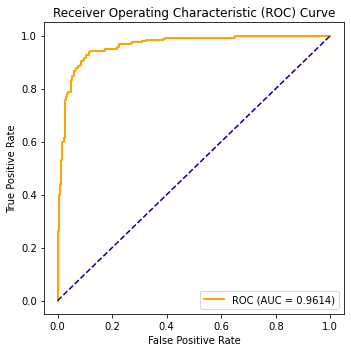

In [48]:
#Plot da curva roc 
fig_size = (5,5)
plot_curva_roc(y_true, y_pred_xception,fig_size)
plt.tight_layout()

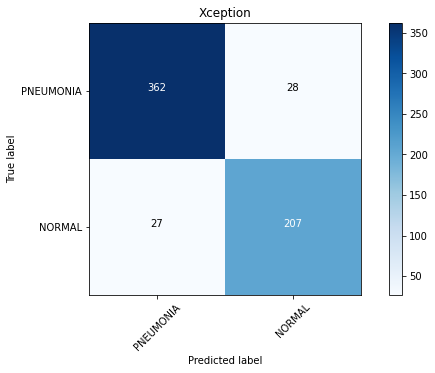

In [49]:
#plot da matriz de confusao
plot_confusion_matrix(cm_test_xception, normalize=False, title='Xception', cmap=plt.cm.Blues)

# 234  imagens - Classe normal
# 390  imagens - classe Pneumonia

## Load Saved Xception Model

In [ ]:
#Testando o carregamento dos pesos.
model_xception_reconstructed = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Projeto_Final_Chest_X-Ray/Pesos_Final/Xception_v1.h5')

history_xception_reconstructed = model_xception_reconstructed.fit(test_batches)
history_xception_reconstructed

20/20 [==============================] - 12s 594ms/step - loss: 1.7361 - binary_accuracy: 0.6426 - precision: 0.6555 - recall: 0.9026 - fn: 38.0000 - fp: 185.0000 - tn: 49.0000 - tp: 352.0000


# Grad Cam

##  Função utilizadas para realizar o Grad-Cam

In [81]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    '''
    img_array = imagem a ser aplicada ao método do grad cam
    
    last_conv_layer_name = nome da última camada convolucional da rede pré-treinada

    model = modelo treinado

    classifier_layer_names = camadas do modelo treinado

    '''

    # ---------- modelo que mapeia a imagem de entrada para as ativações da  última camada convolucional ---------- #
    # modelo que mapeia a imagem de entrada para as ativações da última camada conv
    #last_conv_layer_name = "conv2d_179"


# make_gradcam_heatmap:
# img_array = x_tf => imagem tranformada em array
# model => model_inception ( sua rede + inception)
# last_conv_layer_name => str ,  Última camada convolucional da camada inception_v3
#classifier_layer_names => lista, ["global_average_pooling2d_4", "dense_4"]

    classifier_layer_names = ["global_average_pooling2d_2", "dense_2"]

    # input_inception está recebendo a camada de entrada da rede inception V3
    input_inception = rede_inception.input

    # last_conv_layer está recebendo a camada "mixed10" da rede inception v3
    last_conv_layer = rede_inception.get_layer(last_conv_layer_name) 

    #last_conv_layer_model está recebendo um modelo, criado atraves da camada de entrada e camada de saida "mixed10"
    last_conv_layer_model = keras.Model(input_inception, last_conv_layer.output) # input  = shape=(None, 400, 400, 3)  - Entrada do meu modelo
                                                                                 # output = shape=(None, 11, 11, 2048) - dtype=float32 - Saída da rede

     # ---------- modelo com a ultima camada convolucional, global average pooling e a ativação ---------- #

    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])       # Entrada: saída da última camada convolucional - Ex.: TensorShape([x, x, x])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model_inception.get_layer(layer_name)(x)                                       # Pega os valores ["global_average_pooling2d", "dense"]
    classifier_model = keras.Model(classifier_input, x)                          # Modelo = entra o tensorshape e sai pela camada de classificação binária


    # Aplica a imagem ao modelo convolucional e computa o gradiente
    with tf.GradientTape() as tape:
        # Calculando as ativações da última camada convolucional
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        # Predições
        preds = classifier_model(last_conv_layer_output)                          # Predição do modelo classifier_input, tendo como saída uma camada densa com uma únidade
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Gradiente da classe predita em relação ao mapa da última camada convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vetor onde cada entrada é a intensidade média do gradiente sobre o feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplica cada canal na matriz do mapa de recursos por "quão importante este canal é" em relação à classe predita 
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Tirando a média e criando o heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalizando
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Função que plota o gradient
def plot_grad(name, heatmap,pred_label,true_label):

  '''
  name =  nome do arquivo

  heatmap = heatmap retornado ao utilizar a função make_gradcam_heatmap

  pred_label = previsões

  true_label = rótulos

  '''
  from IPython.display import Image
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  # Adicionando um simples pré-processamento
  img_path = name 
  img = keras.preprocessing.image.load_img(img_path,target_size = (400,400)) # Reescalando
  img = keras.preprocessing.image.img_to_array(img)                          # Transformando em matriz

  # Reescalando o heatmap para a faixa de 0-255
  heatmap = np.uint8(255 * heatmap)

  # Função de cor para o heatmap
  jet = cm.get_cmap("jet")

  # Imagem criada com um heatmap ,usando valores RGB 
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Imagem criada com um heatmap ,usando valores RGB 
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Sobreposição na imagem original
  superimposed_img = jet_heatmap * 0.45 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  #plt.title(f'Pneumonia:{float((y_pred[label]*100)):.2f}%\nRótulo verdadeiro: {int(y_true[label])}')
  plt.imshow(superimposed_img)


In [82]:
# Transformando a imagem para o modo tensorflow
def tensorflow_mode(img):
  array = keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(img, axis=0)
  return array


def preprocessing_gradcam(diretorio):

    # Adicionando um simples pré-processamento
    img_path = diretorio 
    img = keras.preprocessing.image.load_img(img_path,target_size = (400,400)) # Reescalando 
    img = keras.preprocessing.image.img_to_array(img)                          # Transformando em matriz
    array = np.expand_dims(img, axis=0)
    array = array/255
    #array = img * (1/255)
    return array


# Computando o gradcam
def gradcam(img,label,y_pred_test,label_test, key):

    # função gradcam:
    # imagens -> diretorio das imagens
    # label -> Numero aleatorio
    # y_pred_test[label] = y_pred do modelo (sua rede + inception) = y_pred_inception[label]
    # label_test = y_true -> Rotulo verdadeiro -> test_batches.labels


    # tensorflow_mode:
    # img_test[label] => img_test é as imagens de test separadas pelo ImageDataGenerator
    # img_test é uma variavel, fora da função.
    # processa a imagem, transforma a imagem em array, e depois expandi a dimensão para axis = zero e retorno um array
    # x_tf = imagem que virou array

    if key =='pneumonia':
        x_tf_new = preprocessing_gradcam(os.path.join(test_pneumonia_dir,test_pneumonia[label-234]))
        

    if key =='normal':
        x_tf_new = preprocessing_gradcam(os.path.join(test_normal_dir,test_normal[label]))

    #x_tf = tensorflow_mode(img_test[label])  # Transformando a imagem para o modo tensorflow
    x_tf = x_tf_new
    print('Imagem localizada')

# make_gradcam_heatmap:
# x_tf => imagem tranformada em array
# model => model_inception ( sua rede + inception)
# last_conv_layer_name => str ,  Última camada convolucional da camada inception_v3
#classifier_layer_names => lista, ["global_average_pooling2d_4", "dense_4"]
# model = model_inception

    # Construindo um heatmap
    heatmap = make_gradcam_heatmap(x_tf,model_inception,last_conv_layer_name,classifier_layer_names)  


# plot_grad:
# img => diretorio das imagens a serem analisadas pelo grad cam
# y_pred_test => y_pred do modelo (sua rede + inception) = y_pred_inception
# label_test => y_true , os rotulos das imagens de teste

    plot_grad(img,heatmap, y_pred_test, y_true)  # Plotando a imagem e o heatmap

## Fase 1 - Grad Cam

In [67]:
# Summary da sua rede + inception
model_inception.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential_65 (Sequential)   (None, 400, 400, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
__________________________________________

In [68]:
# Pegando a layer inception_v3
rede_inception = model_inception.get_layer('inception_v3')

# Analisando o summary da rede para ver o nome da última camada convolucional
rede_inception.summary()                         

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 199, 199, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 199, 199, 32) 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 199, 199, 32) 0           batch_normalization_8[0][0]      
_______________________________________________________________________________________

In [83]:
# Última camada convolucional da camada inception_v3
last_conv_layer_name = 'mixed10'
 
# Camadas do nosso modelo treinado
classifier_layer_names = ["global_average_pooling2d_2", "dense_2"]     

In [84]:
#Pegando as img_test e y_true

# img_test -> formato imageDataGeneretor -> (32, 400, 400, 3)
# label_test -> y_true
img_test, label_test = test_batches.__getitem__(0)

# y_pred é igual o y da predição do modelo
y_pred = y_pred_inception

# y_predict => y_pred_inception
y_pred_test = y_pred_inception

## Fase 2 - Grad Cam

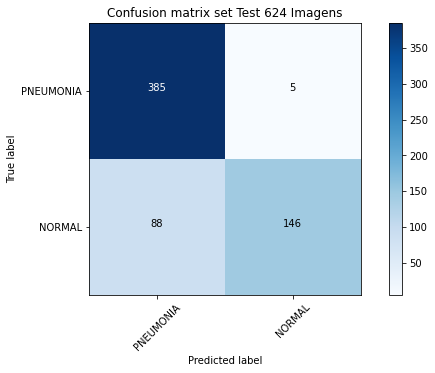

In [71]:
#y_pred = model_inception.predict_generator(test_batches)
y_pred_inception_new = y_pred_inception.round().reshape(y_pred_inception.shape[0],)

# Encontrando os index onde o predict ficou diferente do teste
index_error = np.where(y_pred_inception_new != y_true)
index_error = index_error[0]

# Index das CORRETAS
index_ok = np.where(y_pred_inception_new == y_true)
index_ok = index_ok[0]


print('Quantidade de ERROS: ', len(index_error))    # 87 + 7 = 94 erros
print('Quantidade de ACERTOS: ', len(index_ok))     # 147+383 = 530 acertos
                                                    # 530 + 94 = 624 imagens de treino

Quantidade de ERROS:  93
Quantidade de ACERTOS:  531


In [72]:
""""
    Explicando o raciocinio da separação dos index de erros encontrados:

    Então, o conjunto de dados de teste foi dividido em duas classes,
    Pneumonia com 390 imagens e Normal com 234.

    Então a index da lista do conjunto de teste da classe Pneumonia, vai de 234 até 623
    e o index da lista do conjunto de teste da classe Normal, vai de 0-233. 
    Essa ordem foi determinada pelo ImageDataGenerator.

    Desta forma concluí-se que, se index de erros encontrados menos 233, for maior que zero,
     este index pertence a classe Pneumonia e se for menor que zero, pertence a classe NORMAL.

"""


'"\n    Explicando o raciocinio da separação dos index de erros encontrados:\n\n    Então, o conjunto de dados de teste foi dividido em duas classes,\n    Pneumonia com 390 imagens e Normal com 234.\n\n    Então a index da lista do conjunto de teste da classe Pneumonia, vai de 234 até 623\n    e o index da lista do conjunto de teste da classe Normal, vai de 0-233. \n    Essa ordem foi determinada pelo ImageDataGenerator.\n\n    Desta forma concluí-se que, se index de erros encontrados menos 233, for maior que zero,\n     este index pertence a classe Pneumonia e se for menor que zero, pertence a classe NORMAL.\n\n'

In [73]:
label_error_pneumonia = []
label_error_normal = []

for i in range(len(index_error)):
    if (index_error[i]-234) < 0:   # index - 233 < 0 então é o index da classe NORMAL
        label_error_normal.append(index_error[i])

    if (index_error[i]-234) >= 0:   # index - 233 > 0 então é o index da classes PNEUMONIA
        label_error_pneumonia.append(index_error[i])  #-len(test_normal)-1

print('Quantidade de erros da Classe NORMAL: ', len(label_error_normal))
print('Quantidade de erros da Classe Pneumonia: ', len(label_error_pneumonia))

Quantidade de erros da Classe NORMAL:  88
Quantidade de erros da Classe Pneumonia:  5


In [74]:
label_ok_pneumonia = []
label_ok_normal = []

for i in range(len(index_ok)):
    if (index_ok[i]-234) < 0:   # index - 233 < 0 então é o index da classe NORMAL
        label_ok_normal.append(index_ok[i])

    if (index_ok[i]-234) >= 0:   # index - 233 > 0 então é o index da classes PNEUMONIA
        label_ok_pneumonia.append(index_ok[i])  #-len(test_normal)-1

print('Quantidade de acertos da Classe NORMAL: ', len(label_ok_normal))
print('Quantidade de acertos da Classe Pneumonia: ', len(label_ok_pneumonia))

Quantidade de acertos da Classe NORMAL:  146
Quantidade de acertos da Classe Pneumonia:  385


In [75]:
# Plotar quantas imagens que foram classificadas erradas?

label_error_pneumonia = label_error_pneumonia[:5]      # quantidade index de erros da classe pneumonia
label_error_normal = label_error_normal[:5]            # quantidade index de erros da classe Normal

# Plotar quantas imagens que foram classificadas Corretas?
label_ok_pneumonia = label_ok_pneumonia[:5]      # quantidade index de erros da classe pneumonia
label_ok_normal = label_ok_normal[:5]            # quantidade index de erros da classe Normal

## Grad Cam - classificação CORRETAS da classe NORMAL

Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada


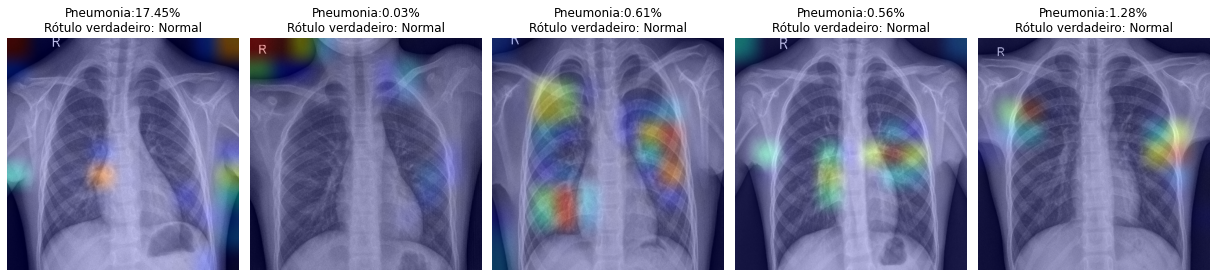

In [85]:
# era NORMAL e foi classificado como NORMAL
plt.figure(figsize=(17,17))

for c, label in enumerate(label_ok_normal):
  plt.subplot(1,len(label_ok_normal),c+1)
  images = os.path.join(test_normal_dir,test_normal[label])
  gradcam(images,label, y_pred_test[label], y_true[label], key='normal')
  plt.title(f'Pneumonia:{float((y_pred[label]*100)):.2f}%\nRótulo verdadeiro: Normal')
  plt.axis('off')
  plt.tight_layout()

## Grad Cam - classificação CORRETAS da classe Pneumonia

Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada


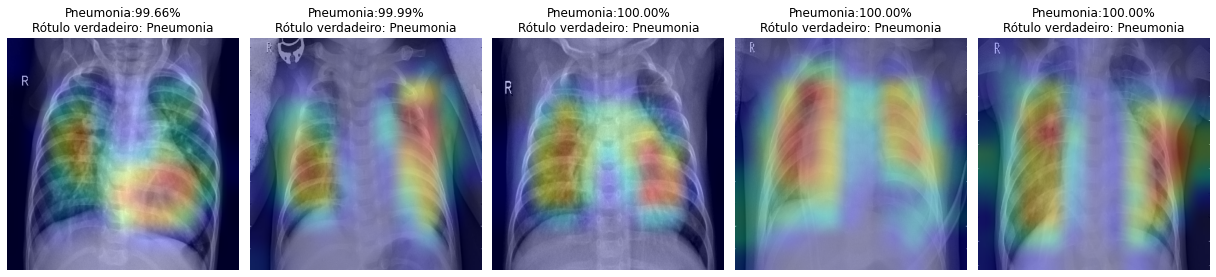

In [86]:
# era PNEUMONIA e foi classificado como PNEUMONIA
plt.figure(figsize=(17,17))

for c, label in enumerate(label_ok_pneumonia):
  plt.subplot(1,len(label_ok_pneumonia),c+1)
  images = os.path.join(test_pneumonia_dir,test_pneumonia[label-234])
  gradcam(images,(label), y_pred_test[label], y_true[label], key='pneumonia')
  plt.title(f'Pneumonia:{float((y_pred[label]*100)):.2f}%\nRótulo verdadeiro: Pneumonia')
  plt.axis('off')
  plt.tight_layout()

## Grad Cam - classificação ERRADAS da classe NORMAL

Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada


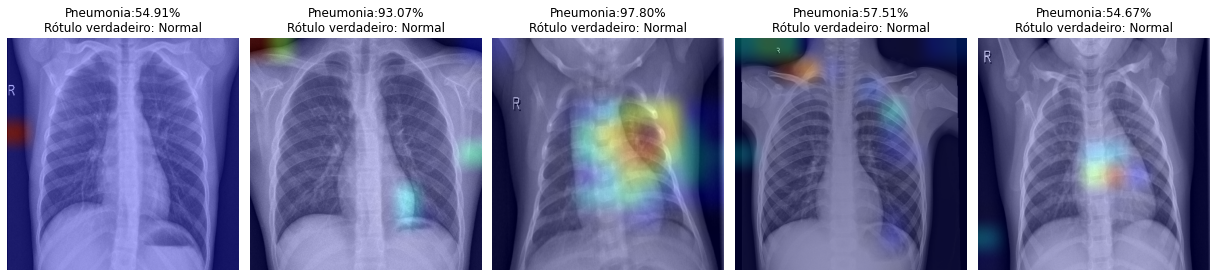

In [87]:
# era NORMAL e foi classificado como PNEUMONIA
plt.figure(figsize=(17,17))

for c, label in enumerate(label_error_normal):
  plt.subplot(1,len(label_error_normal),c+1)
  images = os.path.join(test_normal_dir,test_normal[label])
  gradcam(images,label, y_pred_test[label], y_true[label], key='normal')
  plt.title(f'Pneumonia:{float((y_pred[label]*100)):.2f}%\nRótulo verdadeiro: Normal')
  plt.axis('off')
  plt.tight_layout()

## Grad Cam - classificação ERRADAS da classe Pneumonia

Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada
Imagem localizada


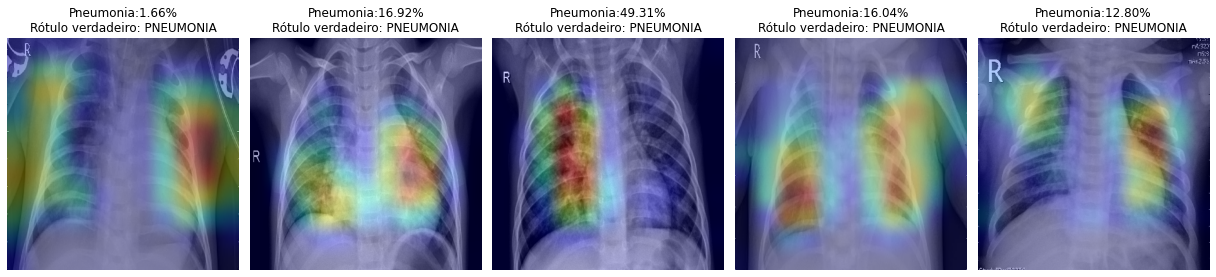

In [88]:
# era PNEUMONIA e foi classificado como NORMAL
plt.figure(figsize=(17,17))
for c, label in enumerate(label_error_pneumonia):
  plt.subplot(1,len(label_error_pneumonia),c+1)
  images = os.path.join(test_pneumonia_dir,test_pneumonia[label-234])
  gradcam(images,label, y_pred_test[label], y_true[label], key='pneumonia')
  plt.title(f'Pneumonia:{float((y_pred[label]*100)):.2f}%\nRótulo verdadeiro: PNEUMONIA')
  plt.axis('off')
  plt.tight_layout()